In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, GRU, Bidirectional, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Neste tutorial veremos como implementar diferentes de técnicas de Redes Neurais Recorrentes (RNN) para análise e previsão de dados sequenciais ou distribuídos no tempo. Para isso vamos usar as camadas LSTM (Long Short-Term Memory), que são camadas especializadas para "lembrar" dos elementos de informação de uma sequência. Se quiser saber mais sobre LSTMs recomendo o vídeo: https://www.youtube.com/watch?v=ZvBJxh5O3H0

Este tutorial é adaptado do post: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Problema modelo

Dado determinado dia de determinado mês, queremos prever o número de passageiros que voarão com a compania aérea X (em unidades de 1000). Os dados cobrem um intervalo de janeiro de 1949 até dezembro de 1960, ou 12 anos, com  144 observações.

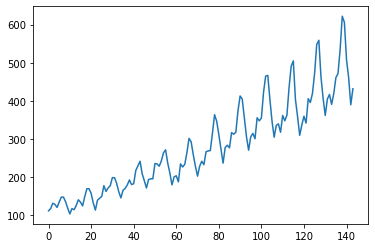

In [2]:
dt = pd.read_csv('./Data/airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dt)
plt.show()

# fixar uma seed para reproducibilidade
np.random.seed(7)

In [3]:
dataset = dt.values
dataset = dataset.astype('float32')

# normalizar o dataset para acelerar o treinamento
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# vamos dividir os dados em treino e teste
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Agora vamos precisar de uma função para organizar os dados da maneira necessária para treinar a rede.

A função toma dois argumentos: o "dataset", que é o array com a info que queremos manipular, e o "look_back", que é o número de obsevações anteriores que será usado como input para que a rede preveja o valor no próximo passo temporal.

A função abaixo vai criar um dataset em que X é o nº de passageiros num momento (t), e Y é o nº de passageiro no próximo momento (t+1) que a rede será treinada a prever.

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# 10 exemplos pra ver o como fica o resultado:
t = create_dataset(dataset[0:10])

print('today, next')
for i in range (len(t[0])):
    print(t[0][i], t[1][i])

today, next
[0.01544401] 0.027027026
[0.02702703] 0.05405405
[0.05405405] 0.04826255
[0.04826255] 0.032818526
[0.03281853] 0.059845567
[0.05984557] 0.08494207
[0.08494207] 0.08494207
[0.08494207] 0.06177607


In [5]:
# reshape X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)

(94, 1, 1) (94,)


In [6]:
# Criar a rede LSTM simples
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# printa as camadas
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [7]:
#treinar
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
94/94 [==============================] - 2s 25ms/step - loss: 0.0284
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 5/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 6/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 7/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 8/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 9/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 10/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 11/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 12/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0021


In [8]:
# fazer as previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 24.67 RMSE
Test error: 48.66 RMSE


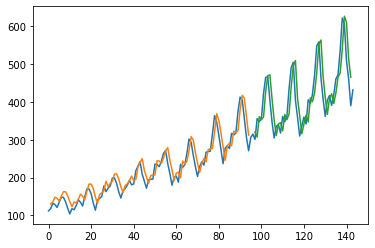

In [9]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Enquanto os dados estão representados em azul, as previsões da rede sobre os dados de treinamento estão mostrados em laranja, e as previsões sobre os dados de teste (que a rede nunca viu antes) estão em verde.

A qualidade do ajuste é evidente.

# Método da Janela

Também podemos adicionar informação de momentos anteriores no modelo para ajudar ele a realizar a previsão do próximo momento.

Isso é chamado de janela, e o tamanho da janela é um parâmetro que deve ser ajustado de acordo com o problema. Neste caso, uma janela de tamanho 3 corresponderia a alimentar ao modelo os momentos com (t), (t-1), e (t-2) como variáveis de input, para ele realizar a previsão do próximo momento (t+1).

In [10]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)

(92, 1, 3) (92,)


In [11]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
92/92 [==============================] - 3s 28ms/step - loss: 0.0181
Epoch 2/50
92/92 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 3/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0054- ETA: 0s - loss:
Epoch 4/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 5/50
92/92 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 6/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 7/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 8/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0037A: 0s - loss: 
Epoch 9/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 10/50
92/92 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 11/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 12/50
92/92 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 13/50
92/92

In [12]:
# fazer as previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 24.62 RMSE
Test error: 42.32 RMSE


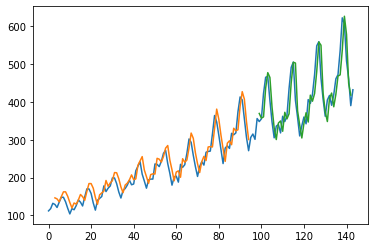

In [13]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Método dos passos temporais

Alguns problemas podem ter um numero variado de passos por amostra. No método dos passos, como no exemplo da janela, tomamos momentos anteriores na nossa série como inputs para prever o output do próximo passo, mas ao invés de usar estes passos como inputs separados nós podemos usá-los como passos do próprio único input.

Fazemos isso através da mesma representação do método da janela, exceto que agora, quando mudamos o formado dos dados, fazemos as o número de colunas igual à dimensão dos passos que queremos e voltamos com a dimensão das features igual a 1.

In [14]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape,trainY.shape)

(92, 3, 1) (92,)


In [15]:
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
92/92 [==============================] - 3s 29ms/step - loss: 0.0218
Epoch 2/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 3/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 4/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 5/50
92/92 [==============================] - 1s 7ms/step - loss: 0.0048
Epoch 6/50
92/92 [==============================] - 1s 7ms/step - loss: 0.0047
Epoch 7/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 8/50
92/92 [==============================] - 1s 7ms/step - loss: 0.0048
Epoch 9/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 10/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 11/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 12/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 13/50
92/92 [=============================

In [16]:
# fazer as previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 23.12 RMSE
Test error: 42.64 RMSE


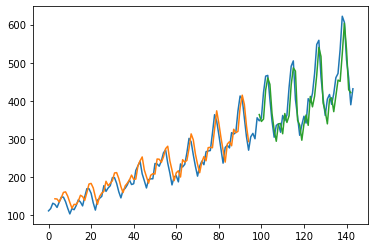

In [17]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Vemos que o resultado é levemente melhor que o exemplo anterior.

# Memória entre os Batches

Normalmente nós resetamos a rede ao fim de cada batch quando treinando o modelo, e também ao usar as funções model.predict() ou model.evaluate(). Nós podemos controlar quando o estado interno das células LSTM são resetadas ao usar o argumento "stateful". Isso significa que ele pode lembrar dos dados em toda a sequência de treino e até manter este estado se precisar realizar previsões.

Este método necessita que os dados de treino não sejam aleatorizados (shuffle=False), e também precisa que resetemos a rede explicitamente depois de cada epoch. Então precisamos criar nosso próprio loop externo de epochs e chamar model.fit() e model.reset_states().

In [37]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape, trainY.shape, testX.shape)

(92, 3, 1) (92,) (44, 3, 1)


In [38]:
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
#train
for i in range(50):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
92/92 [==============================] - 2s 25ms/step - loss: 0.0049
Epoch 1/1
92/92 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0048
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 1/1
92/92 [==============================] - 0s 5ms/step 

In [40]:
# fazer as previsões
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 24.72 RMSE
Test error: 69.25 RMSE


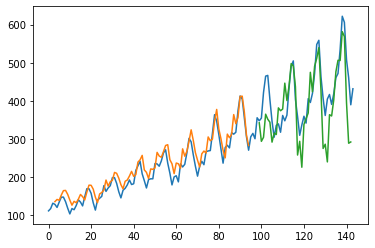

In [41]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Stack de LSMS com memória entre Batches

Agora vamos combinar o método anterior com o fato que podemos combinar diferentes camadas de LSTM em arquiteturas profundas.

In [42]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape,trainY.shape)

(92, 3, 1) (92,)


In [43]:
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), return_sequences=True, stateful=True))
model.add(LSTM(16, stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [45]:
for i in range(50):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
92/92 [==============================] - 4s 42ms/step - loss: 0.0065
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0087
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0079
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0073
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0066
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0059
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0052
Epoch 1/1
92/92 [==============================] - 1s 9ms/step

In [46]:
# fazer as previsões
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 20.15 RMSE
Test error: 51.66 RMSE


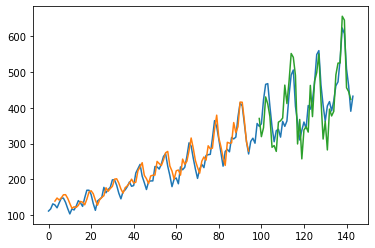

In [47]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM Bidirecionais

Também é possível combinar duas camadas LSTM que vão em direções diferentes no tempo e assim, têm melhor precisão. O keras permite a construção de camadas bidirecionais de maneira muito fácil.

In [54]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape,trainY.shape)

(92, 3, 1) (92,)


In [55]:
batch_size = 1
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=False), batch_input_shape=(batch_size, look_back, 1)))
model.add(Bidirectional(LSTM(8, stateful=False)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (1, 3, 64)                8704      
_________________________________________________________________
bidirectional_4 (Bidirection (1, 16)                   4672      
_________________________________________________________________
dense_12 (Dense)             (1, 1)                    17        
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.fit(trainX, trainY, epochs=70, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/70
92/92 [==============================] - 6s 64ms/step - loss: 0.0154
Epoch 2/70
92/92 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 3/70
92/92 [==============================] - 1s 10ms/step - loss: 0.0041
Epoch 4/70
92/92 [==============================] - 1s 11ms/step - loss: 0.0040: 
Epoch 5/70
92/92 [==============================] - 1s 10ms/step - loss: 0.0043
Epoch 6/70
92/92 [==============================] - 1s 10ms/step - loss: 0.0040
Epoch 7/70
92/92 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 8/70
92/92 [==============================] - 1s 10ms/step - loss: 0.0039
Epoch 9/70
92/92 [==============================] - 1s 10ms/step - loss: 0.0036
Epoch 10/70
92/92 [==============================] - 1s 15ms/step - loss: 0.0035: 0s -
Epoch 11/70
92/92 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 12/70
92/92 [==============================] - 1s 13ms/step - loss: 0.0037: 0s - lo
Epoch 13/70
92/92 [==

In [57]:
# fazer as previsões
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 23.28 RMSE
Test error: 41.93 RMSE


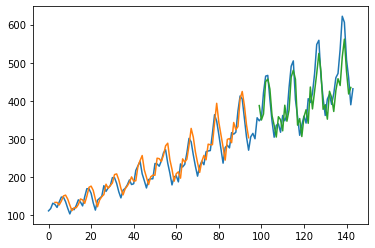

In [58]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Time-Distributed

O wrapper Time-Distributed do Keras permite criar uma camada para cada fatia temporal do input. COmbinando isso com camadas densas resulta em um modelo profundo capaz de fazer mais assosciações e obter melhor precisão.

In [99]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape,trainY.shape)

(92, 3, 1) (92,)


In [100]:
batch_size = 1
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True), batch_input_shape=(batch_size, look_back, 1)))
model.add(TimeDistributed(Dense(16)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (1, 3, 64)                8704      
_________________________________________________________________
time_distributed_12 (TimeDis (1, 3, 16)                1040      
_________________________________________________________________
flatten_11 (Flatten)         (1, 48)                   0         
_________________________________________________________________
dense_44 (Dense)             (1, 1)                    49        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


In [101]:
for i in range(50):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
92/92 [==============================] - 7s 78ms/step - loss: 0.0064
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0084
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0049
Epoch 1/1
92/92 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0043
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0042
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 1/1
92/92 [==============================] - 1s 8ms/

In [102]:
# fazer as previsões
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# reconverter os valores pra algo inteligível
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular a raiz do erro médio quadrado
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train error: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test error: %.2f RMSE' % (testScore))

Train error: 25.82 RMSE
Test error: 49.60 RMSE


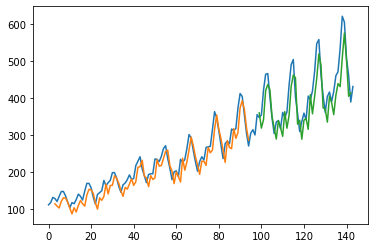

In [103]:
# ajustar as coisas pra plotar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Previsão de longo prazo (em construção)

Agora que vimos diversas técnicas de implementação, vale a pena lembrar que a redes que utilizam LSTM tomam uma série de estados passados para prever o próximo estado imediato.

A seguir, vamos tentar fazer previsões de longo prazo utilizando sucessivas previsões da mesma rede.

In [156]:
# reshape X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input para [amostras, passos temporais, info]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape, trainY.shape, testY.shape)

(92, 3, 1) (92,) (44,)


In [190]:
batch_size = 1
model = Sequential()
model.add(LSTM(32, stateful=True, batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 32)                   4352      
_________________________________________________________________
dense_47 (Dense)             (1, 1)                    33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [191]:
for i in range(50):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
92/92 [==============================] - 7s 78ms/step - loss: 0.0052
Epoch 1/1
92/92 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0075A: 0s - lo
Epoch 1/1
92/92 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0060
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0053
Epoch 1/1
92/92 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 1/1
92/92 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 1/1
92/92 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 1/1
92/92 [==============================] - 1s

In [287]:
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

preds = []
for i in range(len(testX)):
    preds.append(testPredict[i][0])
    
    
steps = 70 # nª de passos no futuro
r = 0 # introduzir aleatoriedade
for i in range(steps):
    basis = np.zeros((1,look_back,1))
    basis[0,:,0] = preds[-look_back:]
    
    r += np.random.rand()/steps/10
    basis[0,-1,0] += r
    
    n_pred = model.predict(basis, batch_size=batch_size)
    preds.append(n_pred[0][0])

preds = np.array(preds)
preds = np.reshape(preds, (len(preds),1))

preds = scaler.inverse_transform(preds)
test_v = scaler.inverse_transform([testY])
print(len(preds), test_v.shape)

114 (1, 44)


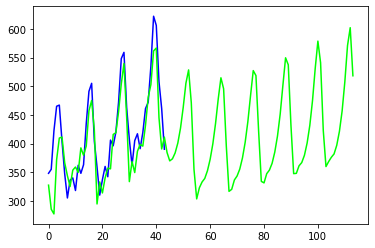

In [288]:
testPredictPlot = np.empty_like(preds)
testPredictPlot[:, :] = np.nan
testPredictPlot[:len(preds)+look_back, :] = preds

# plot
plt.plot(np.transpose(test_v), c='b')
plt.plot(testPredictPlot, c='lime')
plt.show()